<a href="https://colab.research.google.com/github/kazars24/mfdp-emotion-detection/blob/main/course%20modules/4.Improving%20models/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 4. Улучшение модели

В данном ноутбуке я подготовил несколько моделей и сравнил их по точности и скорости работы.

**Детекция лица на изображении.** Для этой задачи были использованы MTCNN из библиотеки facenet_pytorch и MTCNN из библиотеки fer.

**Распознавание эмоций.**Были рассмотрены следующие модели:


1.   Алгоритм из fer;
2.   InceptionResnetV1(pretrained='vggface2') с файнтюнингом на Facial Affect Dataset(short);
3. InceptionResnetV1(pretrained='casia-webface') с файнтюнингом на Facial Affect Dataset(short);
4. InceptionResnetV1 с обучением на Facial Affect Dataset(short).

Проверка моделей осуществлялась на валидационной части датасета Facial Affect Dataset(short) и на тестовой части датасета RAF Face Database (к нему мне, к сожалению, предоставили доступ накануне дедлайна).

Используемый инструменты версионирования экспериментов - clearML.


## Установка и импорт библиотек

In [ ]:
!pip install datasets
!pip install torcheval
!pip install facenet_pytorch
!pip install clearml
!pip install FER

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN, InceptionResnetV1, training

from fer import FER

from datasets import load_dataset

from clearml import Task, Logger

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Загузка и подготовка данных

### Facial Affect Dataset(short)

In [ ]:
t_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

def transforms_train(examples):
    examples['image'] = [t_train(image) for image in examples['image']]
    return examples

def transforms_val(examples):
    examples['image'] = [t_val(image) for image in examples['image']]
    return examples

def change_class(examples):
    if examples['label'] == 7:
        examples['label'] = 2
    return examples

In [ ]:
dataset_train = load_dataset("Mauregato/affectnet_short", split='train')
dataset_train = dataset_train.filter(lambda example: example['label'] in [0, 1, 3, 4, 5, 6, 7])
dataset_train = dataset_train.map(change_class)
dataset_train.set_transform(transforms_train)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/23233 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/5809 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Mauregato___parquet/Mauregato--affectnet_short-a81fcd4fd630aaba/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Filter:   0%|          | 0/23233 [00:00<?, ? examples/s]

Map:   0%|          | 0/20936 [00:00<?, ? examples/s]

In [ ]:
dataset_val = load_dataset("Mauregato/affectnet_short", split='val')
dataset_val = dataset_val.filter(lambda example: example['label'] in [0, 1, 3, 4, 5, 6, 7])
dataset_val = dataset_val.map(change_class)
dataset_val.set_transform(transforms_val)

Filter:   0%|          | 0/5809 [00:00<?, ? examples/s]

Map:   0%|          | 0/5235 [00:00<?, ? examples/s]

Было:

'0': anger

'1': surprise

'2': contempt

'3': happy

'4': neutral

'5': fear

'6': sad

'7': disgust

Стало:

In [ ]:
class_names = {0: 'angry',
               1: 'surprise',
               2: 'disgust',
               3: 'happy',
               4: 'neutral',
               5: 'fear',
               6: 'sad'}

In [ ]:
def collate_fn(data):
    images = []
    labels = []
    for x in data:
        images.append(x['image'])
        labels.append(x['label'])
    images = torch.stack(images)
    labels = torch.LongTensor(labels)
    return images, labels

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=False, num_workers=2, collate_fn=collate_fn)

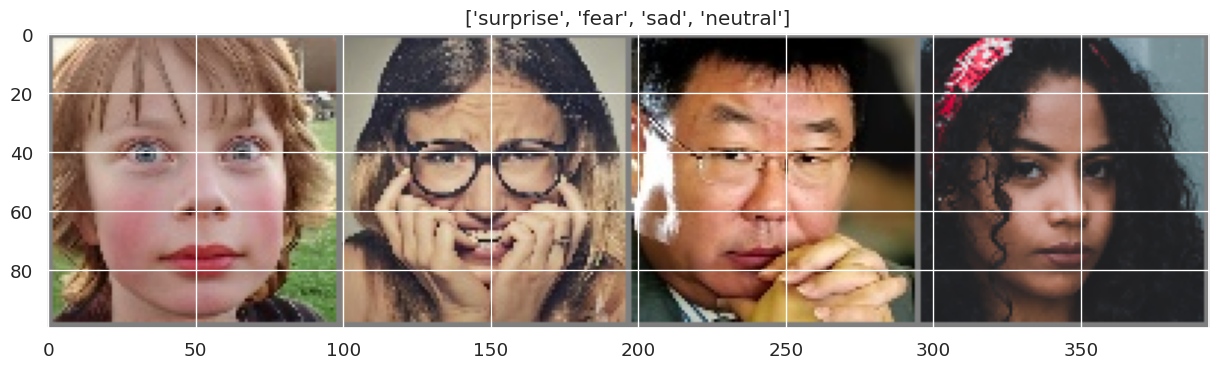

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


one_batch= next(iter(train_loader))
inputs = one_batch[0][:4]
classes = one_batch[1][:4].tolist()

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### RAF Face Database

In [ ]:
!unzip /content/drive/MyDrive/raf_face_dataset/original.zip -d /content/raf_face/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/raf_face/original/train_07272.jpg  
  inflating: /content/raf_face/original/train_07273.jpg  
  inflating: /content/raf_face/original/train_07274.jpg  
  inflating: /content/raf_face/original/train_07275.jpg  
  inflating: /content/raf_face/original/train_07276.jpg  
  inflating: /content/raf_face/original/train_07277.jpg  
  inflating: /content/raf_face/original/train_07278.jpg  
  inflating: /content/raf_face/original/train_07279.jpg  
  inflating: /content/raf_face/original/train_07280.jpg  
  inflating: /content/raf_face/original/train_07281.jpg  
  inflating: /content/raf_face/original/train_07282.jpg  
  inflating: /content/raf_face/original/train_07283.jpg  
  inflating: /content/raf_face/original/train_07284.jpg  
  inflating: /content/raf_face/original/train_07285.jpg  
  inflating: /content/raf_face/original/train_07286.jpg  
  inflating: /content/raf_face/original/train_07287.jpg  
  in

In [ ]:
with open('/content/list_patition_label.txt') as file:
    #lines = [line.rstrip() for line in file if 'test_' in line]
    test_img_files = []
    for line in file:
        if 'test_' in line:
            name, label = line.rstrip().split(' ')
            test_img_files.append([name, int(label)])


In [ ]:
raf_labels = {
    1: 'surprise',
    2: 'fear',
    3: 'disgust',
    4: 'happy',
    5: 'sad',
    6: 'angry',
    7: 'neutral',
}

In [ ]:
face_transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

## Подбор оптимальной модели InceptionResnetV1

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
%env CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
env: CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI


In [ ]:
!clearml-init

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
env: CLEARML_WEB_HOST=https://app.clear.ml env: CLEARML_API_HOST=https://api.clear.ml env: CLEARML_FILES_HOST=https://files.clear.ml env: CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI env: CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI
Could not parse credentials, please try entering them manually.
Enter user access key: F6KM2HNXU0U5VQ0GYLTI
Enter user secret: 9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI
Detected credentials key="F6KM2HNXU0U5VQ0GYLTI" secret="9SY1***"

Editing configuration file: /root/clearml.conf
Enter the url of the clearml-server's Web service, for exampl

In [ ]:
#task.close()
task = Task.init(
    project_name='Emotion detection',
    task_name='InceptionResnet_12_epochs',
    tags=['Resnet'])

ClearML Task: created new task id=fe468e8f356049fcbd1f82dceb62d2ec
ClearML results page: https://app.clear.ml/projects/736f880e3e524d439d09aceba8f7065d/experiments/fe468e8f356049fcbd1f82dceb62d2ec/output/log


In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=7).to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.002)
scheduler = MultiStepLR(optimizer, [5, 10])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 12

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    41/41   | loss:    3.2201 | fps: 1067.8918 | acc:    0.1171   

Epoch 1/12
----------
Train |   164/164  | loss:    1.0795 | fps:  606.4460 | acc:    0.5773   
Valid |    41/41   | loss:    0.9218 | fps: 1190.2207 | acc:    0.6396   

Epoch 2/12
----------
Train |   164/164  | loss:    0.8820 | fps:  610.7009 | acc:    0.6580   
Valid |    41/41   | loss:    1.0000 | fps: 1221.0951 | acc:    0.6110   

Epoch 3/12
----------
Train |   164/164  | loss:    0.8006 | fps:  610.7762 | acc:    0.6882   
Valid |    41/41   | loss:    0.8195 | fps: 1114.2926 | acc:    0.6757   

Epoch 4/12
----------
Train |   164/164  | loss:    0.7484 | fps:  603.3078 | acc:    0.7130   
Valid |    41/41   | loss:    0.8187 | fps: 1200.0386 | acc:    0.6837   

Epoch 5/12
----------
Train |   164/164  | loss:    0.7036 | fps:  602.0923 | acc:    0.7326   
Valid |    41/41   | loss:    0.7773 | fps: 1138.6843 | acc:    0.7057   

Epoch 6/12
----------
Train |   164/164  | loss: 

In [ ]:
torch.save(resnet.cpu().state_dict(), 'resnet_w.pt')
torch.save(resnet.cpu(), 'resnet_m.pt')

In [ ]:
model = torch.load('resnet_m.pt')
model.load_state_dict(torch.load('resnet_w.pt'))
model = model.to(device).eval()

**1 вариант**

optimizer = optim.Adam(resnet.parameters(), lr=0.001)

scheduler = MultiStepLR(optimizer, [5, 10])

epochs = 50

Epoch 25/50

Train |   164/164  | loss:    0.0369 | fps:  652.7657 | acc:    0.9894

Valid |    41/41   | loss:    1.5283 | fps: 1019.7770 | acc:    0.7177


---

**2 варинт**

optimizer = optim.Adam(resnet.parameters(), lr=0.001)

scheduler = MultiStepLR(optimizer, [5, 10, 25])

epochs = 25

Epoch 25/50


Train |   164/164  | loss:    0.0099 | fps:  635.7694 | acc:    0.9968

Valid |    41/41   | loss:    1.7658 | fps: 1227.5382 | acc:    0.7221

---

**3 варинт**

те же параметры, но без трансформеров

Epoch 25/25

Train |   164/164  | loss:    0.0074 | fps:  667.8474 | acc:    0.9973

Valid |    41/41   | loss:    1.5966 | fps: 1305.4291 | acc:    0.7284

---

**4 вариант**

```
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.5, hue=.3),
transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
transforms.RandomRotation(30),
transforms.RandomAutocontrast(),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
```

Epoch 25/25

Train |   164/164  | loss:    0.7078 | fps:  328.3875 | acc:    0.7258

Valid |    41/41   | loss:    0.7317 | fps: 1101.8282 | acc:    0.7150

---


In [ ]:
#task.close()
task = Task.init(
    project_name='Emotion detection',
    task_name='InceptionResnet_casiawebface',
    tags=['Resnet'])

ClearML Task: created new task id=cc3c12b7935b4f428e719710518452b7
ClearML results page: https://app.clear.ml/projects/736f880e3e524d439d09aceba8f7065d/experiments/cc3c12b7935b4f428e719710518452b7/output/log


In [ ]:
resnet_v2 = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=7).to(device)

In [ ]:
optimizer = optim.Adam(resnet_v2.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 12

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet_v2.eval()
training.pass_epoch(
    resnet_v2, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet_v2.train()
    training.pass_epoch(
        resnet_v2, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_v2.eval()
    training.pass_epoch(
        resnet_v2, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    41/41   | loss:    2.5793 | fps: 1253.3569 | acc:    0.1563   

Epoch 1/12
----------
Train |   164/164  | loss:    0.9585 | fps:  658.8128 | acc:    0.6217   
Valid |    41/41   | loss:    0.8096 | fps: 1291.5667 | acc:    0.6665   

Epoch 2/12
----------
Train |   164/164  | loss:    0.7870 | fps:  653.9941 | acc:    0.6980   
Valid |    41/41   | loss:    0.8431 | fps: 1563.1660 | acc:    0.6595   

Epoch 3/12
----------
Train |   164/164  | loss:    0.7241 | fps:  666.0323 | acc:    0.7235   
Valid |    41/41   | loss:    0.7677 | fps: 1142.4084 | acc:    0.7007   

Epoch 4/12
----------
Train |   164/164  | loss:    0.6703 | fps:  646.7523 | acc:    0.7464   
Valid |    41/41   | loss:    0.7318 | fps: 1179.5142 | acc:    0.7140   

Epoch 5/12
----------
Train |   164/164  | loss:    0.5009 | fps:  660.9759 | acc:    0.8166   
Valid |    41/41   | loss:    0.7051 | fps: 1204.0734 | acc:    0.7382   

Epoch 6/12
----------
Train |   164/164  | loss: 

In [ ]:
pkl_filename = 'resnet_casiawebface.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(resnet_v2.cpu(), file)

In [ ]:
#torch.save(resnet_v2.cpu().state_dict(), 'resnet_casiawebface_w.pt')
#torch.save(resnet_v2.cpu(), 'resnet_casiawebface_m.pt')

Пока это лучший варинт!

In [ ]:
resnet_v3 = InceptionResnetV1(
    classify=True,
    pretrained=None,
    num_classes=7).to(device)

In [ ]:
optimizer = optim.Adam(resnet_v3.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 12

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet_v3.eval()
training.pass_epoch(
    resnet_v3, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet_v3.train()
    training.pass_epoch(
        resnet_v3, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_v3.eval()
    training.pass_epoch(
        resnet_v3, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    41/41   | loss:    1.9442 | fps: 1303.5554 | acc:    0.1180   

Epoch 1/12
----------
Train |   164/164  | loss:    2.0707 | fps:  622.9452 | acc:    0.1474   
Valid |    41/41   | loss:    1.9625 | fps: 1182.6060 | acc:    0.1480   

Epoch 2/12
----------
Train |   164/164  | loss:    2.0787 | fps:  612.3345 | acc:    0.1423   
Valid |    41/41   | loss:    1.9616 | fps: 1137.2207 | acc:    0.1518   

Epoch 3/12
----------
Train |   164/164  | loss:    2.0759 | fps:  620.5189 | acc:    0.1456   
Valid |    41/41   | loss:    1.9643 | fps: 1202.0725 | acc:    0.1462   

Epoch 4/12
----------
Train |   164/164  | loss:    2.0705 | fps:  622.6099 | acc:    0.1415   
Valid |    41/41   | loss:    1.9627 | fps: 1142.7405 | acc:    0.1491   

Epoch 5/12
----------
Train |   164/164  | loss:    2.0748 | fps:  636.4794 | acc:    0.1397   
Valid |    41/41   | loss:    1.9609 | fps: 1219.0349 | acc:    0.1514   

Epoch 6/12
----------
Train |   164/164  | loss: 

В итоге получили, что модель с наибольшей точностью на валидации - это resnet_v2 = InceptionResnetV1(classify=True, pretrained='casia-webface', num_classes=7), где для обучения использовалось:
1.   12 эпох;
2.   optimizer = optim.Adam(resnet_v2.parameters(), lr=0.001);
3.   scheduler = MultiStepLR(optimizer, [4, 8]).

## Тестирование

Для корректно проверки работоспособности моделей мне показалось мало пропустить алгоритм на валидационной части, потому что нейросети были обучены на похожих картинках, значит результат на них будет более менее стабильный. Потому я дополнительно провери модели на данных из дургого датасета.

Начем с FaceNet

**Facial Affect Dataset(short)**

In [ ]:
pkl_filename = '/content/drive/MyDrive/resnet_casiawebface.pkl'
with open(pkl_filename, 'rb') as file:
    resnet = pickle.load(file)

In [ ]:
resnet = resnet.to(device).eval()
mtcnn = MTCNN(factor=0.8, keep_all=True, device=device).eval()

In [ ]:
dataset_val = load_dataset("Mauregato/affectnet_short", split='val')
dataset_val = dataset_val.filter(lambda example: example['label'] in [0, 1, 3, 4, 5, 6, 7])
dataset_val = dataset_val.map(change_class)
dataset_val.set_transform(transforms_val)

In [ ]:
matched = []
time_per_img = []

for item in dataset_val:
    img = item['image'].to(device)
    img = torch.unsqueeze(img, 0)
    true_lbl = class_names[item['label']]

    start_time = time.time()
    pred_class = int(torch.argmax(resnet(img), dim=1))
    time_per_img.append(time.time() - start_time)

    pred_lbl = class_names[pred_class]
    matched.append(true_lbl == pred_lbl)

print(f"Среднее время на 1 кадр: {sum(time_per_img) / len(time_per_img)}")
print(f"Accuracy: {sum(matched) / len(matched)}")

Среднее время на 1 кадр: 0.019882560983200584
Accuracy: 0.7319961795606494


**RAF Face Database**

In [ ]:
mtcnn = MTCNN(factor=0.99, keep_all=True, device=device).eval()

In [ ]:
time_per_img = []
matched = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face/original/' + item[0]
    true_lbl = raf_labels[item[1]]
    with Image.open(img_name) as img:
        img.load()

    start_time = time.time()

    faces_bbox, _ = mtcnn.detect(img)

    faces = []
    emotion = ''
    try:
        for box in faces_bbox:
            faces.append(img.crop(box))
        for face in faces:
            face = face_transform(face)
            face = face.to(device)
            face = torch.unsqueeze(face, 0)
            pred_class = int(torch.argmax(resnet(face), dim=1))
            emotion = class_names[pred_class]
    except:
        emotion = 'no_face'
        no_f_count += 1

    time_per_img.append(time.time() - start_time)
    matched.append(true_lbl == emotion)
    #print(true_lbl, emotion)


print(f"Среднее время на 1 кадр: {sum(time_per_img) / len(time_per_img)}")
print(f"Accuracy: {sum(matched) / len(matched)}")
print(f"всего: {len(matched)}")
print(f"кол-во без лиц: {no_f_count}")

Среднее время на 1 кадр: 0.810415838501444
Accuracy: 0.23565840938722293
всего: 3068
кол-во без лиц: 39


Точность получилась низкая. А на один кадр уходит порядка 0.8 секунды, что очень много для продукта, который должен работать в режиме реального времени. Также стоит отметить, что не на всех изображениях удалось разпознать лица, хотя они там точность есть.

Теперь перейдем к алгоритму, реализованному в бибилиотеке fer.

**Facial Affect Dataset(short)**

In [ ]:
detector = FER(mtcnn=True)

In [ ]:
dataset_val = load_dataset("Mauregato/affectnet_short", split='val')
dataset_val = dataset_val.filter(lambda example: example['label'] in [0, 1, 3, 4, 5, 6, 7])
dataset_val = dataset_val.map(change_class)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/23233 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/5809 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Mauregato___parquet/Mauregato--affectnet_short-a81fcd4fd630aaba/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Filter:   0%|          | 0/5809 [00:00<?, ? examples/s]

Map:   0%|          | 0/5235 [00:00<?, ? examples/s]

In [ ]:
time_per_img = []
matched = []
no_f_count = 0

for item in dataset_val:
    img = np.array(item['image'])
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    true_lbl = class_names[item['label']]
    #cv2_imshow(img)

    start_time = time.time()

    captured_emotions = detector.detect_emotions(img)
    if captured_emotions:
        emotion = max(captured_emotions[0]['emotions'], key=captured_emotions[0]['emotions'].get)
    else:
        emotion = 'no_face'
        no_f_count += 1

    time_per_img.append(time.time() - start_time)
    matched.append(true_lbl == emotion)

print(f"Среднее время на 1 кадр: {sum(time_per_img) / len(time_per_img)}")
print(f"Accuracy: {sum(matched) / len(matched)}")
print(f"всего: {len(matched)}")
print(f"кол-во без лиц: {no_f_count}")

Среднее время на 1 кадр: 0.07438221077978212
Accuracy: 0.41260744985673353
всего: 5235
кол-во без лиц: 10


**RAF Face Database**

In [ ]:
time_per_img = []
matched = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face/original/' + item[0]
    true_lbl = raf_labels[item[1]]
    img = cv2.imread(img_name)

    start_time = time.time()

    captured_emotions = detector.detect_emotions(img)
    if captured_emotions:
        emotion = max(captured_emotions[0]['emotions'], key=captured_emotions[0]['emotions'].get)
    else:
        emotion = 'no_face'
        no_f_count += 1

    time_per_img.append(time.time() - start_time)
    matched.append(true_lbl == emotion)

print(f"Среднее время на 1 кадр: {sum(time_per_img) / len(time_per_img)}")
print(f"Accuracy: {sum(matched) / len(matched)}")
print(f"всего: {len(matched)}")
print(f"кол-во без лиц: {no_f_count}")

Среднее время на 1 кадр: 0.2575759767242641
Accuracy: 0.5342242503259452
всего: 3068
кол-во без лиц: 427


## YOLOv8

В качестве эксперимента было интересно попробовать YOLOv8. К сожалению, данные для этой идеи оказались очень грязными, потому результаты получились слабыми.

In [ ]:
import os
import shutil
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
expr_list = ['angry','disgust','fear','happy','sad','surprise','neutral']
plot_Expr_list = [0, 1, 2, 3, 4, 5, 6]

def read_lst(lst_file):
	with open(lst_file, 'r') as f:
		lines = f.readlines()
	lines = [l.strip() for l in lines]
	data = {'name': [] , 'face_id': [] , 'ymin':[] , 'xmin':[], 'xmax': [] , 'ymax':[], 'confidence':[], 'emotion':[]}
	for l in lines:
		l = l.split(" ")
		data['name'].append(l[0])
		data['face_id'].append(int(l[1]))
		data['ymin'].append(int(l[2]))
		data['xmin'].append(int(l[3]))
		data['xmax'].append(int(l[4]))
		data['ymax'].append(int(l[5]))
		data['confidence'].append(float(l[6]))
		data['emotion'].append(int(l[7]))
	df = pd.DataFrame.from_dict(data)
	return df

In [ ]:
labels = read_lst('archive/label/label.lst')
labels.head()

In [ ]:
labels.shape

(91793, 8)

In [ ]:
unique_imgs = labels['name'].unique()
unique_train, unique_val = train_test_split(unique_imgs, test_size=0.25, random_state=777)
labels_train = labels[labels['name'].isin(unique_train)]
labels_val = labels[labels['name'].isin(unique_val)]
print(labels_train.shape)
print(labels_val.shape)

(68733, 8)
(23060, 8)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from pathlib import Path

def plot_bboxes(image_file, bboxes, xywh=True, labels=None):

    fig = plt.figure()

    # add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])

    image_folder = Path(image_file).parent

    # read and plot the image
    image = plt.imread(image_file)
    plt.imshow(image)

    # Iterate over all the bounding boxes
    for i, bbox in enumerate(bboxes):
        if xywh:
          xmin, ymin, w, h = bbox
        else:
          xmin, ymin, xmax, ymax = bbox
          w = xmax - xmin
          h = ymax - ymin

        # add bounding boxes to the image
        box = patches.Rectangle(
            (xmin, ymin), w, h, edgecolor="red", facecolor="none"
        )

        ax.add_patch(box)

        if labels is not None:
          rx, ry = box.get_xy()
          cx = rx + box.get_width()/2.0
          cy = ry + box.get_height()/8.0
          l = ax.annotate(
            labels[i],
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
          )
          l.set_bbox(
            dict(facecolor='red', alpha=0.5, edgecolor='red')
          )

In [ ]:
# xmin, ymin, xmax, ymax format

to_dir = 'ExpW/images/train/'
from_dir = 'archive/origin/'
for x in labels_train['name'].unique():
    #print(labels_train.iloc[i])
    x_labels = labels[labels['name'] == x]
    img_name = x
    old_img_path = from_dir + img_name
    new_img_path = to_dir + img_name
    new_label_path = 'ExpW/labels/train/' + img_name.split('.')[0] + '.txt'
    img = cv2.imread(old_img_path)
    new_label = []
    for i in range(x_labels.shape[0]):
        ymin, xmin, xmax, ymax = x_labels.iloc[i][2:6]
        w = xmax - xmin
        h = ymax - ymin
        x_c = (xmin + w / 2) / img.shape[1]
        y_c = (ymin + h / 2) / img.shape[0]

        new_label.append(f"{int(x_labels.iloc[i]['emotion'])} {x_c} {y_c} {w / img.shape[1]} {h / img.shape[0]}")
    shutil.move(old_img_path, new_img_path, copy_function = shutil.copytree)
    with open(new_label_path, "w") as f:
        for line in new_label:
            f.write(line)

In [ ]:
to_dir = 'ExpW/images/val/'
from_dir = 'archive/origin/'
for x in labels_val['name'].unique():
    #print(labels_train.iloc[i])
    x_labels = labels[labels['name'] == x]
    img_name = x
    old_img_path = from_dir + img_name
    new_img_path = to_dir + img_name
    new_label_path = 'ExpW/labels/val/' + img_name.split('.')[0] + '.txt'
    img = cv2.imread(old_img_path)
    new_label = []
    for i in range(x_labels.shape[0]):
        ymin, xmin, xmax, ymax = x_labels.iloc[i][2:6]
        w = xmax - xmin
        h = ymax - ymin
        x_c = (xmin + w / 2) / img.shape[1]
        y_c = (ymin + h / 2) / img.shape[0]

        new_label.append(f"{int(x_labels.iloc[i]['emotion'])} {x_c} {y_c} {w / img.shape[1]} {h / img.shape[0]}")
    shutil.move(old_img_path, new_img_path, copy_function = shutil.copytree)
    with open(new_label_path, "w") as f:
        for line in new_label:
            f.write(line)

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip /content/drive/MyDrive/expw_yolo_format/datasets.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: datasets/expw/labels/val/awe_lady_938.txt  
  inflating: datasets/expw/labels/val/heartbroken_lady_398.txt  
  inflating: datasets/expw/labels/val/fierce_actor_296.txt  
  inflating: datasets/expw/labels/val/astound_actor_166.txt  
  inflating: datasets/expw/labels/val/shocked_expression_275.txt  
  inflating: datasets/expw/labels/val/fierce_face_422.txt  
  inflating: datasets/expw/labels/val/amazed_student_163.txt  
  inflating: datasets/expw/labels/val/distressed_son_401.txt  
  inflating: datasets/expw/labels/val/crying_worker_283.txt  
  inflating: datasets/expw/labels/val/fierce_programmer_846.txt  
  inflating: datasets/expw/labels/val/astound_son_874.txt  
  inflating: datasets/expw/labels/val/disgust_manager_818.txt  
  inflating: datasets/expw/labels/val/amazed_father_427.txt  
  inflating: datasets/expw/labels/val/expressionless_woman_139.txt  
  inflating: datasets/expw/labels/val/awe_son_329.t

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
%env CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
env: CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI


In [ ]:
!clearml-init

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
env: CLEARML_WEB_HOST=https://app.clear.ml env: CLEARML_API_HOST=https://api.clear.ml env: CLEARML_FILES_HOST=https://files.clear.ml env: CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI env: CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI
Could not parse credentials, please try entering them manually.
Enter user access key: F6KM2HNXU0U5VQ0GYLTI
Enter user secret: 9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI
Detected credentials key="F6KM2HNXU0U5VQ0GYLTI" secret="9SY1***"

Editing configuration file: /root/clearml.conf
Enter the url of the clearml-server's Web service, for exampl

In [ ]:
from clearml import Task, Logger

task = Task.init(
    project_name='Emotion detection',
    task_name='Yolov8n_5epochs_v2',
    tags=['Yolov8n'])

In [ ]:
import torch
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [ ]:
model.train(data='expw.yaml', epochs=5, batch=16, name='yolov8n_v8_50e')

Ultralytics YOLOv8.0.114 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=expw.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False,

Результаты ожидаемо получисль не очень. Но было очень интересно проверить такой варинт.

P.S. Colab начал ругаться и прерывать выполение, поэтому модель не обучилась до самого конца.